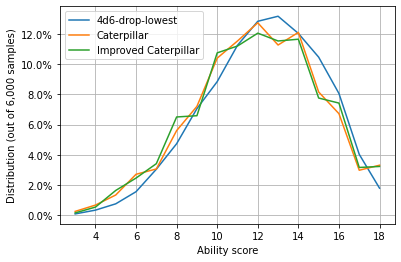

,4d6-drop-lowest,Caterpillar,Improved Caterpillar
count,6000.0,6000.0,6000.0
mean,12.3,12.0,12.0
std,2.88,3.08,3.1
min,3.0,3.0,3.0
25%,10.0,10.0,10.0
50%,12.0,12.0,12.0
75%,14.0,14.0,14.0
max,18.0,18.0,18.0


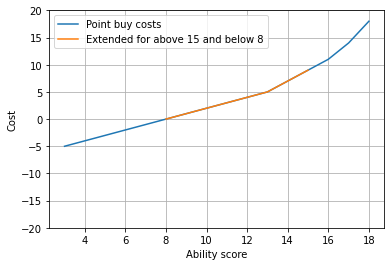

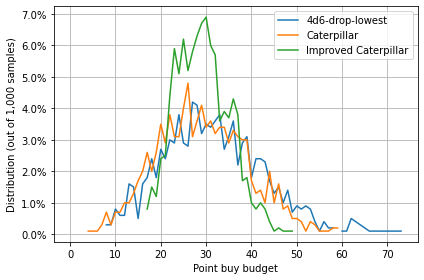

,4d6-drop-lowest,Caterpillar,Improved Caterpillar
count,1000.0,1000.0,1000.0
mean,31.2,29.2,29.2
std,10.8,9.98,5.91
min,-,4.0,17.0
25%,23.8,22.0,25.0
50%,31.0,29.0,29.0
75%,39.0,36.0,33.0
max,73.0,59.0,49.0


,4d6-drop-lowest,Caterpillar,Improved Caterpillar
Scenario 1,16.8%,14.1%,6.0%
Scenario 2,33.7%,26.5%,14.9%
Scenario 3,8.0%,6.8%,0.6%
Scenario 4,16.3%,16.3%,8.6%


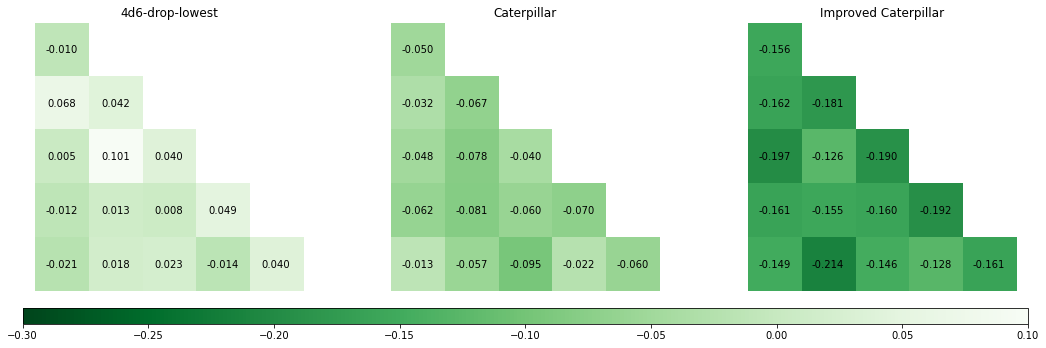

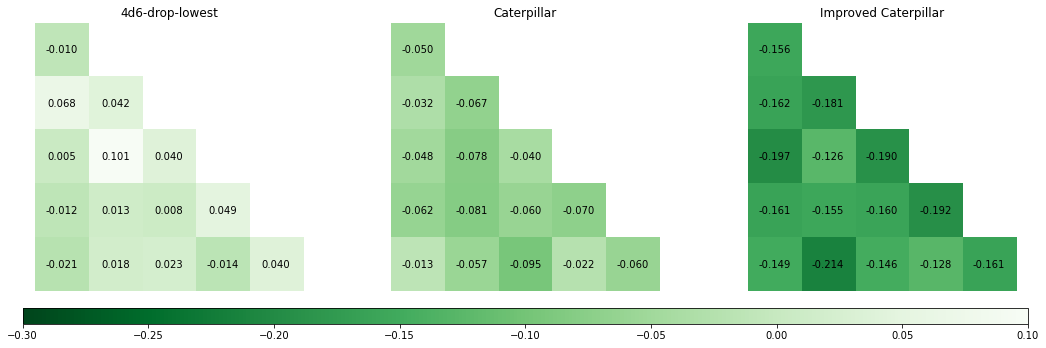

In [1]:
# Set up link to python code

from myst_nb import glue
from importlib import reload

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append("../src/")

import CorrelationAnalysis
import StatArrays
import PandasHelper


# Generate stats
num_iterations = 1_000
stats_to_generate = {
  "4d6-drop-lowest" : StatArrays.four_d_six_drop_lowest,
  "Caterpillar" : StatArrays.caterpillar_stat_array,
  "Improved Caterpillar" : StatArrays.caterpillar_stat_array2,
}
stats = pd.concat([
  PandasHelper.stats_arrays_to_pd(
    [stat_generator() for i in range(num_iterations)],
    stat_label
  ) for stat_label, stat_generator in stats_to_generate.items()
  ], 
  axis=1
)
point_buy = stats.replace(StatArrays.point_buy_dict).groupby("iter").sum()
totals = stats.groupby("iter").sum()

# Line plot function
line_plot = lambda ax, df, c: ax.plot(df.index, df[c], label=c)

# Create stat distribution graph
fig, axes = plt.subplots()
stat_counts = PandasHelper.create_counts(stats, normalize=True)
[line_plot(axes, stat_counts, c) for c in stat_counts.columns]
num_samples = StatArrays.num_ability_scores*num_iterations
axes.set_ylabel(f"Distribution (out of {num_samples:,} samples)")
axes.set_xlabel("Ability score")
percent_formatter = matplotlib.ticker.PercentFormatter(xmax=1, decimals=1)
axes.yaxis.set_major_formatter(percent_formatter)
axes.legend()
axes.grid(True)
glue("stats_distribution_fig", fig, display=False)
plt.close()
# fig.close()

# Create summary stats
summary_stats = stats.describe().applymap(PandasHelper.sig_figs, nsigfigs=3)
glue("summary_stats_df", summary_stats, display=False)

# Create fig of point buy cost schedule
point_buy_costs = [[k, v] for k, v in StatArrays.point_buy_dict.items()]
point_buy_costs_df = pd.DataFrame(point_buy_costs, columns = ["Score", "Cost"])
point_buy_orig = point_buy_costs_df.loc[ \
  (point_buy_costs_df.Score >= 8) \
  & (point_buy_costs_df.Score <= 15)
]
point_buy_fig, axes = plt.subplots()
axes.plot(point_buy_costs_df.Score, point_buy_costs_df.Cost, label="Point buy costs")
axes.plot(point_buy_orig.Score, point_buy_orig.Cost, label="Extended for above 15 and below 8")
axes.set_ylabel(f"Cost")
axes.set_xlabel("Ability score")
axes.set_ylim(-20, 20)
axes.legend()
axes.grid(True)
glue("point_buy_fig", point_buy_fig, display=False)
plt.close()

point_buy_dist_fig, axes = plt.subplots()
line_plot = lambda ax, df, c: ax.plot(df.index, df[c], label=c)

# Create point buy budget distribution
point_buy_counts = PandasHelper.create_counts(point_buy, normalize=True)
[line_plot(axes, point_buy_counts, c) for c in point_buy_counts.columns]
axes.set_ylabel(f"Distribution (out of {num_iterations:,} samples)")
percent_formatter = matplotlib.ticker.PercentFormatter(xmax=1, decimals=1)
axes.yaxis.set_major_formatter(percent_formatter)
axes.set_xlabel("Point buy budget")
axes.legend()
axes.grid(True)

point_buy_dist_fig.tight_layout()
glue("point_buy_dist_fig", point_buy_dist_fig, display=False)
plt.close()

# Create summary of point buy budget
point_buy_summ = point_buy.describe().applymap(PandasHelper.sig_figs, nsigfigs=3)
glue("summary_point_buy_df", point_buy_summ, display=False)

# Create stat array scenarios
stats_above_15 = (stats > 15).groupby("iter").sum()
stats_above_13 = (stats > 13).groupby("iter").sum()
stats_below_10 = (stats < 10).groupby("iter").sum()

## % of records with 2+ stats above 15 and only 0 or 1 stat below 10
scenario1 = ((stats_above_15 >= 2) & (stats_below_10 <= 1)).mean()

## % of records with 3+ stats above 13 and only 0 or 1 stat below 10
scenario2 = ((stats_above_13 >= 3) & (stats_below_10 <= 1)).mean()

## % of records with only 0 or 1 stat above 15 and 3+ stats below 10
scenario3 = ((stats_above_15 <= 1) & (stats_below_10 >= 3)).mean()

## % of records with only 0 or 1 stats above 13 and 2+ stats below 10
scenario4 = ((stats_above_13 <= 1) & (stats_below_10 >= 2)).mean()

scenarios = pd.concat(
  [scenario1, scenario2, scenario3, scenario4], 
  axis=1,
  keys=["Scenario "+str(i) for i in range(1,5)]).T
scenarios = scenarios[["4d6-drop-lowest", "Caterpillar", "Improved Caterpillar"]]
scenarios = scenarios.applymap(lambda x: "{:.1%}".format(x))
glue("scenarios_df", scenarios, display=False)

# # Correlation analysis
reload(CorrelationAnalysis)
corr_fig = CorrelationAnalysis.analyse(stats)
glue("corr_fig", corr_fig, display=False)